In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras 
from keras.layers import Dense
import json 
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
import unicodedata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.pyplot as plt
import re
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import nltk
from nltk import ngrams
from collections import Counter



In [2]:
question  =[]
answer = []
with open("data/chat.txt",'r') as f :
    for line in f :
        line  =  line.split('\t')
        question.append(line[0])
        answer.append(line[1])
print(len(question) == len(answer))

True


In [3]:
question[:5]

['hi, how are you doing?',
 "i'm fine. how about yourself?",
 "i'm pretty good. thanks for asking.",
 'no problem. so how have you been?',
 "i've been great. what about you?"]

In [4]:
answer[:5]

["i'm fine. how about yourself?\n",
 "i'm pretty good. thanks for asking.\n",
 'no problem. so how have you been?\n',
 "i've been great. what about you?\n",
 "i've been good. i'm in school right now.\n"]

In [5]:
answer = [ i.replace("\n","") for i in answer]

In [6]:
answer[:5]

["i'm fine. how about yourself?",
 "i'm pretty good. thanks for asking.",
 'no problem. so how have you been?',
 "i've been great. what about you?",
 "i've been good. i'm in school right now."]

In [7]:
data = pd.DataFrame({"question" : question ,"answer":answer})
data.head()

,question,answer
0,"hi, how are you doing?",i'm fine. how about yourself?
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.
2,i'm pretty good. thanks for asking.,no problem. so how have you been?
3,no problem. so how have you been?,i've been great. what about you?
4,i've been great. what about you?,i've been good. i'm in school right now.


In [8]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

In [9]:
def clean_text(text):
    text = unicode_to_ascii(text.lower().strip())
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"\r", "", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
    text = text.translate(str.maketrans('', '', string.punctuation)) 
    text = re.sub("(\\W)"," ",text) 
    text = re.sub('\S*\d\S*\s*','', text)
    text =  "<sos> " +  text + " <eos>"
    return text
    

In [10]:
data["question"][0]

'hi, how are you doing?'

In [11]:
data["question"] = data.question.apply(clean_text)

In [12]:
data["question"][0]

'<sos> hi how are you doing <eos>'

In [13]:
data["answer"] = data.answer.apply(clean_text)

In [14]:
question  = data.question.values.tolist()
answer =  data.answer.values.tolist()

In [15]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

    return tensor, lang_tokenizer

In [16]:
input_tensor , inp_lang  =  tokenize(question)

In [17]:
target_tensor , targ_lang  =  tokenize(answer)

In [ ]:
 #len(inp_question) ==  len(inp_answer)

In [18]:
def remove_tags(sentence):
    return sentence.split("<start>")[-1].split("<end>")[0]

In [19]:
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]


In [20]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

In [ ]:
#print(len(train_inp) , len(val_inp) , len(train_target) , len(val_target))

In [21]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 22]), TensorShape([64, 22]))

In [22]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x,hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [23]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))


Encoder output shape: (batch size, sequence length, units) (64, 22, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [24]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [25]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 22, 1)


In [26]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights


In [27]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 2357)


In [28]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [29]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([targ_lang.word_index['<sos>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [30]:
EPOCHS = 40

for epoch in range(1, EPOCHS + 1):
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

    if(epoch % 4 == 0):
        print('Epoch:{:3d} Loss:{:.4f}'.format(epoch,
                                          total_loss / steps_per_epoch))

Epoch:  4 Loss:1.5705
Epoch:  8 Loss:1.3377
Epoch: 12 Loss:1.1582
Epoch: 16 Loss:0.9987
Epoch: 20 Loss:0.8338
Epoch: 24 Loss:0.6514
Epoch: 28 Loss:0.4636
Epoch: 32 Loss:0.2744
Epoch: 36 Loss:0.1391
Epoch: 40 Loss:0.0645


In [31]:
def evaluate(sentence):
    sentence = clean_text(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<sos>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<eos>':
            return remove_tags(result), remove_tags(sentence)

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return remove_tags(result), remove_tags(sentence)

In [32]:
questions  =[]
answers = []
with open("data/chat.txt",'r') as f :
    for line in f :
        line  =  line.split('\t')
        questions.append(line[0])
        answers.append(line[1])
print(len(question) == len(answer))

True


In [33]:
def ask(sentence):
    result, sentence = evaluate(sentence)

    print('Question: %s' % (sentence))
    print('Predicted answer: {}'.format(result))
ask(questions[100])

Question: <sos> i believe so <eos>
Predicted answer: good i hope it does not cool off this weekend <eos> 


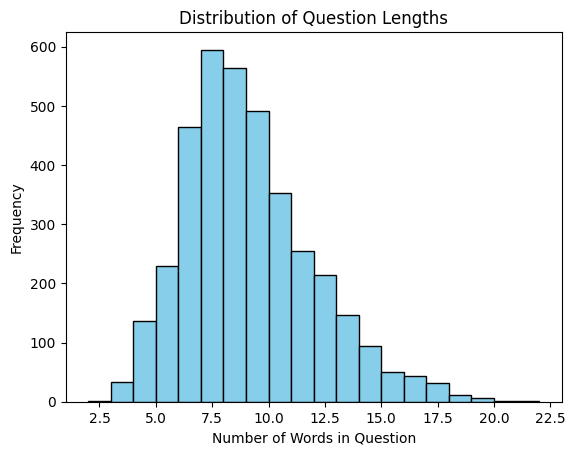

In [34]:

question_lengths = [len(q.split()) for q in question]

# Plotting the distribution
plt.hist(question_lengths, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Question Lengths')
plt.xlabel('Number of Words in Question')
plt.ylabel('Frequency')
plt.show()

In [35]:
print(answers[50])

that's how i feel, i want winter to come soon.



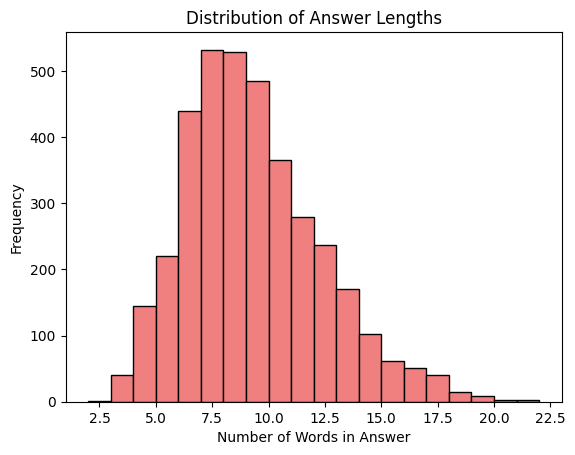

In [36]:
# Assuming 'answer' is a list containing your answers
answer_lengths = [len(a.split()) for a in answer]

# Plotting the distribution
plt.hist(answer_lengths, bins=20, color='lightcoral', edgecolor='black')
plt.title('Distribution of Answer Lengths')
plt.xlabel('Number of Words in Answer')
plt.ylabel('Frequency')
plt.show()

Top 10 most frequent words in questions:
[('sos', 3725), ('eos', 3725), ('i', 1270), ('you', 972), ('the', 764), ('is', 710), ('to', 683), ('it', 652), ('a', 636), ('that', 522)]

Top 10 most frequent words in answers:
[('sos', 3725), ('eos', 3725), ('i', 1284), ('you', 959), ('the', 760), ('it', 694), ('is', 690), ('to', 668), ('a', 651), ('that', 524)]


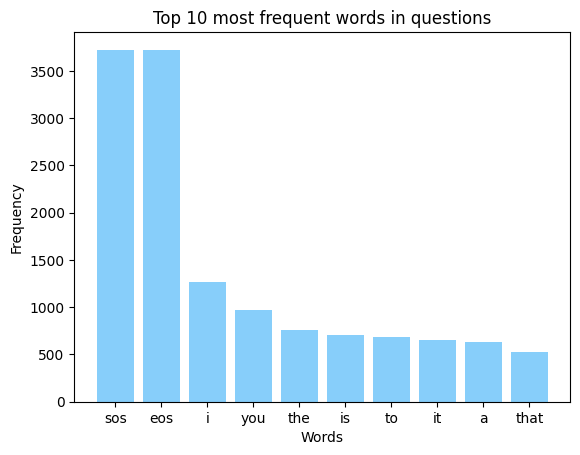

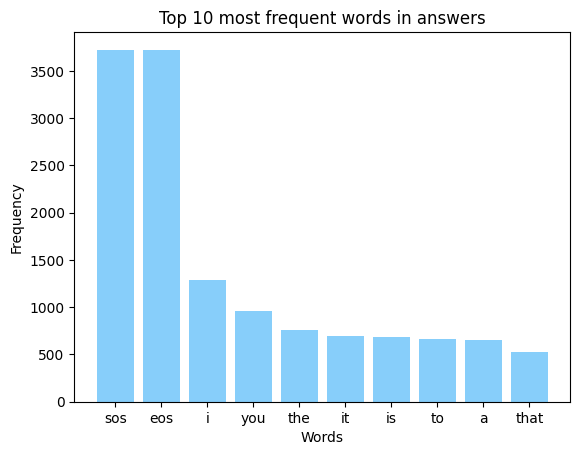

In [37]:
all_questions = ' '.join(question)
all_answers = ' '.join(answer)

# Function to preprocess text (remove punctuation and convert to lowercase)
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    return text

# Preprocess the text
all_questions = preprocess_text(all_questions)
all_answers = preprocess_text(all_answers)

# Tokenize the text
question_tokens = all_questions.split()
answer_tokens = all_answers.split()

# Calculate the most frequent words
question_word_freq = Counter(question_tokens)
answer_word_freq = Counter(answer_tokens)

# Display the most common words
print("Top 10 most frequent words in questions:")
print(question_word_freq.most_common(10))

print("\nTop 10 most frequent words in answers:")
print(answer_word_freq.most_common(10))

# Plotting the distribution of the most frequent words
def plot_word_frequency(word_freq, title):
    words, counts = zip(*word_freq.most_common(10))
    plt.bar(words, counts, color='lightskyblue')
    plt.title(title)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.show()

# Plot the distribution of the most frequent words
plot_word_frequency(question_word_freq, 'Top 10 most frequent words in questions')
plot_word_frequency(answer_word_freq, 'Top 10 most frequent words in answers')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\chama\AppData\Roaming\nltk_data...


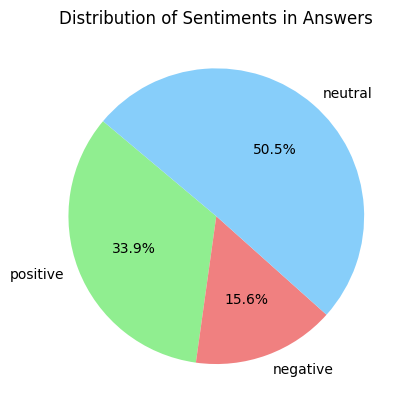

In [38]:
# Download the VADER sentiment analysis model (if not already downloaded)
nltk.download('vader_lexicon')

# Assuming 'answer' is a list containing your answers
all_answers = ' '.join(answer)

# Function to get sentiment polarity
def get_sentiment_polarity(text):
    sid = SentimentIntensityAnalyzer()
    sentiment_scores = sid.polarity_scores(text)
    # Classify the compound score as positive, negative, or neutral
    if sentiment_scores['compound'] >= 0.05:
        return 'positive'
    elif sentiment_scores['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply sentiment analysis to each answer
answer_sentiments = [get_sentiment_polarity(a) for a in answer]

# Count the occurrences of each sentiment
sentiment_counts = Counter(answer_sentiments)

# Plotting the distribution of sentiments
labels, counts = zip(*sentiment_counts.items())
colors = ['lightgreen', 'lightcoral', 'lightskyblue']

plt.pie(counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Sentiments in Answers')
plt.show()

In [39]:
# Assuming 'question' and 'answer' are lists containing your questions and answers
all_questions = ' '.join(question)
all_answers = ' '.join(answer)

# Function to get n-grams
def get_ngrams(text, n):
    tokens = nltk.word_tokenize(text)
    return list(ngrams(tokens, n))

# Function to get common n-grams
def get_common_ngrams(text, n, top_n=10):
    ngram_list = get_ngrams(text, n)
    ngram_counts = Counter(ngram_list)
    return ngram_counts.most_common(top_n)

# Specify the value of n for n-grams
n_value = 2  # You can change this to 3, 4, etc., for different n-grams

# Get common n-grams for questions and answers
common_question_ngrams = get_common_ngrams(all_questions, n_value)
common_answer_ngrams = get_common_ngrams(all_answers, n_value)

# Display common n-grams
print(f"Top {n_value}-grams in questions:")
print(common_question_ngrams)

print(f"\nTop {n_value}-grams in answers:")
print(common_answer_ngrams)

Top 2-grams in questions:
[(('<', 'sos'), 3725), (('sos', '>'), 3725), (('<', 'eos'), 3725), (('eos', '>'), 3725), (('>', '<'), 3725), (('>', 'i'), 782), (('>', 'that'), 218), (('that', 'is'), 215), (('it', 'is'), 195), (('>', 'what'), 181)]

Top 2-grams in answers:
[(('<', 'sos'), 3725), (('sos', '>'), 3725), (('<', 'eos'), 3725), (('eos', '>'), 3725), (('>', '<'), 3725), (('>', 'i'), 738), (('that', 'is'), 215), (('>', 'that'), 211), (('it', 'is'), 197), (('>', 'it'), 167)]
